# Exercice 13) Deep Deterministic Policy Gradients and Proximal Policy Optimization

In this exercise we will investigate two state-of-the-art algorithms: deep deterministic policy gradient (DDPG) and proximal policy optimization (PPO).

We will examine their performance on [Goddard's rocket problem](https://github.com/osannolik/gym-goddard).
This environment comes prepackaged in this notebook's folder, so it can be just imported.

```
First formulated by R. H. Goddard around 1910, this is a classical problem within dynamic optimization and optimal control. The task is simply to find the optimal thrust profile for a vertically ascending rocket in order for it to reach the maximum possible altitude, given that its mass decreases as the fuel is spent and that it is subject to varying drag and gravity.
```

The gym's observation space is the rocket's vertical position, velocity and mass, which are normalized for you to be within $[0, 1]$.

The rocket engine is assumed to be throttled such that the thrust can be continuously controlled between 0 to some maximum limit, which translates to an action space $\mathcal U \in [0, 1]$.

![](rocket_spacex.jpg)
(Photo by <a href="https://unsplash.com/@spacex?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">SpaceX</a> on <a href="https://unsplash.com/s/photos/rocket?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>)
  

In order for the full notebook to run through, you will also need the stable-baslines3 package.

```
pip install stable-baselines3[extra]
```

In [1]:
from rocket_env import GoddardEnv
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from stable_baselines3 import PPO, DDPG, A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from copy import deepcopy

OPTIMAL_CONTROL = 0.0122079818367078
RANDOM_AVG = 0.00995
RANDOM_BEST = 0.01148

## 1) DDPG

Deep Deterministic Policy Gradient (DDPG) was first introduced [2015](https://arxiv.org/abs/1509.02971).
It uses four neural networks to interact on the continuous state and action space.
The first two we already know from the last exercise introduced Actor-Critic method: a critic to estimate the q-value function and an actor which deterministicly - completely trained - should give us the best action for a specific state with respect to the q-value function.
Additionally, DDPG provides two target networks which are (in the beginning) copies of the actor and critic. These target networks are updated time-delayed in a low-pass filter manner.
This enhances stability during the learning process because the networks used to calculate the target are not directly updated on the fly.
For more information see for example [here](https://spinningup.openai.com/en/latest/algorithms/ddpg.html).

During the learning process the critic is updated based on minimizing (!) the following loss function:

\begin{equation}
\mathcal L(w, {\mathcal D}) = \underset{(x,u,r,x',d) \sim {\mathcal D}}{{\mathrm E}}\left[
    \Bigg(  \left(r + \gamma \hat{q}_{}(x',\pi(x', \theta^-), w^-) \right) - \hat{q}(x,u, w) \Bigg)^2
    \right].
\end{equation}   

Here, the target is calculated using the target networks. $w$ and $w^-$ are the parameters of the critic and critic-target networks $\hat{q}$, respectively and $\theta^-$ define the parameters of the actor-target network.

The policy/actor network is updated based on the idea to maximize (!) the expected return

\begin{align}
    \max_{\theta} \underset{x \sim {\mathcal D}}{{\mathrm E}}\left[\hat{q}(x, \pi_{}(x, \theta), w) \right],
\end{align}  

where $\theta$ are the parameters of the policy network $\pi$.

The updates are performed off-policy by sampling from an experience replay buffer ${\mathcal D}$.
Since we are dealing with an deterministic actor, exploration during training is achieved by adding noise to the sampled actions.

### Task: Implement the DDPG with PyTorch
Write a DDPG algorithm using the Algo. 13.1 in lecture slides 13!
A lot of the functions and classes are already given because we switch our framework here from Tensorflow to [PyTorch](https://pytorch.org/).
There are a lot of tutorials on the PyTorch website to get familiar with how you can perform the update steps which will be most of your work in the follwoing cells.

Execute the following cell to make use of the defined multi layer perceptron and the plot function!

In [2]:
def mlp(sizes, activation, output_activation=nn.Identity):
    """
    Defines a multi layer perceptron using pytorch layers and activation funtions
    """
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def plot_reward_trends(logs):
    repeats = len(logs['envs'])
    ncols = 2
    nrows = int(np.ceil(repeats / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8, nrows*4), sharex=True, sharey=True)
    for ax, _env, _model in zip(axes.flatten(), logs['envs'], logs['models']):
        ax.plot(_env.get_episode_rewards(), label='rewards', color='green')

        ax.set_ylabel('Reward')
        ax.set_xlabel('Episode')
        ax.set_ylim(0, 0.015)
        ax.axhline(OPTIMAL_CONTROL, ls='--', color='red', label='optimal')
        ax.axhline(RANDOM_BEST, ls='--', color='orange', label='best rnd actions')
        ax.axhline(RANDOM_AVG, ls='--', color='yellow', label='average rnd actions')
        ax.legend(loc='lower left')
        ax2 = ax.twinx()
        ax2.plot(_env.get_episode_lengths(), label='ep lengths')
        ax2.legend()
        ax2.set_ylabel('Steps')
    fig.tight_layout()

def test_agent(logs):
    """Deterministic test of the agent in the given env"""    
    num_test_episodes = 400
    for i, (env, agent) in enumerate(zip(logs['envs'], logs['models'])):
        episode_reward = 0
        episode_len = 0
        state = env.reset()
        for j in tqdm(range(num_test_episodes)):
            episode_len += 1
            action = agent.decide(state, deterministic=True)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            env.render()
            state = next_state
            if done:
                state = env.reset()
                break

        print(f'Reward during test ({i}): {episode_reward}')
        env.close()
    print('Optimal control: 0.0122')

        

Execute the following cells to make use of the predefined actor & critic and the replay buffer!


In [3]:
class Actor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation=nn.ReLU, act_limit=1):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Sigmoid)
        self.act_limit = act_limit

    def forward(self, state):
        return self.act_limit * self.pi(state)

    def act(self, state):
        with torch.no_grad():
            return self.act_limit * self.pi(state).numpy()
    

class Critic(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation=nn.ReLU):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, state, action):
        # torch.cat concatenates action to state

        q = self.q(torch.cat([state, action], dim=-1))
        return torch.squeeze(q, -1)  # To ensure q has right shape.
    
class ReplayBuffer:

        def __init__(self, obs_dim, action_dim, buffer_size):
            
            self.state_buf = np.zeros((buffer_size, obs_dim), dtype=np.float32)
            self.next_state_buf = np.zeros((buffer_size, obs_dim), dtype=np.float32)
            self.action_buf = np.zeros((buffer_size, action_dim), dtype=np.float32)
            self.reward_buf = np.zeros(buffer_size, dtype=np.float32)
            self.done_buf = np.zeros(buffer_size, dtype=np.float32)
            self.ptr, self.size, self.max_size = 0, 0, buffer_size

        def push(self, state, action, reward, next_state, done):
            
            self.state_buf[self.ptr] = state
            self.next_state_buf[self.ptr] = next_state
            self.action_buf[self.ptr] = action
            self.reward_buf[self.ptr] = reward
            self.done_buf[self.ptr] = done
            self.ptr = (self.ptr + 1) % self.max_size
            self.size = min(self.size + 1, self.max_size)

        def fetch(self, batch_size=32):
            
            idxs = np.random.randint(0, self.size, size=batch_size)
            
            batch = dict(state=self.state_buf[idxs],
                         next_state=self.next_state_buf[idxs],
                         action=self.action_buf[idxs],
                         reward=self.reward_buf[idxs],
                         done=self.done_buf[idxs])
            
            return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in batch.items()}

Here, fill in the following code template to write a DDPG agent!

In [4]:
class DDPG_agent:
    """Reference:
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ddpg/ddpg.py
    """    
    
    def __init__(self, env, actor_hidden_size, actor_number_layers, critic_hidden_size, critic_number_layers,
                 buffer_size, actor_lr, critic_lr, gamma, batch_size, learning_starts, tau):#, action_noise):
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.batch_size = batch_size
        self.learning_starts = learning_starts
        self.gamma = gamma
        self.tau = tau

        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.shape[0]
        

        # define A&C and the replaybuffer        
        self.actor = None
        self.critic = None
        self.replay_buffer = None
        
        ### BEGIN SOLUTION
        self.actor = Actor(obs_dim, act_dim, [actor_hidden_size] * actor_number_layers, nn.ReLU)
        self.critic = Critic(obs_dim, act_dim, [critic_hidden_size] * critic_number_layers, nn.ReLU)
        self.replay_buffer = ReplayBuffer(obs_dim, act_dim, buffer_size)
        ### END SOLUTION
        
        # defines target networks
        self.actor_target = deepcopy(self.actor)
        self.critic_target = deepcopy(self.critic)
        
        # Uses Adam optimizer (see to ex12 for more explanation)
        self.actor_optimizer = Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=critic_lr)

        # define action noise space for clipping
        self.action_space_high = env.action_space.high
        self.action_space_low = env.action_space.low

    def q_loss(self, data):
        ### BEGIN SOLUTION
        
        state, action, rerwad, next_state, done = data['state'], data['action'], data['reward'], data['next_state'], data['done']
            
        # Gradient descent for Q-function
        self.critic_optimizer.zero_grad()
        q = self.critic.forward(state, action)
        with torch.no_grad():
            q_pi_targ = self.critic_target.forward(next_state, self.actor_target.forward(next_state))
            backup = rerwad + self.gamma * (1 - done) * q_pi_targ
            
        # MSE loss against Bellman backup
        return ((q - backup) ** 2).mean()
    
        ### END SOLUTION
    
    def pi_loss(self, data):
        """
        Calulate the loss for a gradient ascent(!) step
        """
        ### BEGIN SOLUTION
        
        state = data['state']
            
        self.actor_optimizer.zero_grad()
        return -self.critic.forward(state, self.actor.forward(state)).mean()

        ### END SOLUTION
        
    
    def deliberate(self, number_updates_per_step=1):
        """
        Fetches number_updates_per_step-times from replay_buffer, computes targets and calculates losses to 
        update the q-function using gradient descent and the policy function using gradient ascent
        In the end updates the target networks
        """

        for _ in range(number_updates_per_step):
            ### BEGIN SOLUTION
        
            data = self.replay_buffer.fetch(self.batch_size)
            
            # Gradient descent for Q-function
            loss_q = self.q_loss(data)
            loss_q.backward()
            self.critic_optimizer.step()

            # Freeze Q-network so you don't waste computational effort
            # computing gradients for it during the policy learning step.
            for p in self.critic.parameters():
                p.requires_grad = False

            # Gradient ascent step for pi.
            loss_pi = self.pi_loss(data)
            loss_pi.backward()
            self.actor_optimizer.step()

            # Unfreeze Q-network so you can optimize it at next DDPG step.
            for p in self.critic.parameters():
                p.requires_grad = True

            # Finally, update target networks by polyak averaging.
            with torch.no_grad():
                # update Critc-target
                for p, p_targ in zip(self.critic.parameters(), self.critic_target.parameters()):
                    # uses in-place operations "mul_", "add_" to update target
                    # params, as opposed to "mul" and "add", which would make new tensors.
                    p_targ.data.mul_(1 - self.tau)
                    p_targ.data.add_((self.tau) * p.data)

                # update Actor-target
                for p, p_targ in zip(self.actor.parameters(), self.actor_target.parameters()):
                    # uses in-place operations "mul_", "add_" to update target
                    # params, as opposed to "mul" and "add", which would make new tensors.
                    p_targ.data.mul_(1 - self.tau)
                    p_targ.data.add_((self.tau) * p.data)
                           
            ### END SOLUTION
            
    def decide(self, state, deterministic=False, noise_scale=0.1):
        """
        Returns action as nd-array depending on the state, adds scaled noise 
        and clips the action depending on the action space
        """
        
        ### BEGIN SOLUTION
        action = self.actor.act(torch.as_tensor(state, dtype=torch.float32))
        
        if deterministic:
            return np.clip(action, self.action_space_low, self.action_space_high)
        else:
            return np.clip(action + 0.1 * np.random.randn(1), self.action_space_low, self.action_space_high)
        ### END SOLUTION
        
                           

Run the following cell to train your agent. Note that, in contrast to classic RL applications, in standard libraries you have often the possibility to update the agent after full episodes instead of stepwise.
This could be helpful in our application due to the sparse reward signal of the rocket environment instead of after each environment step.
To overcome this issue we introduce the variable `learning_starts` and run here first 500 steps in the environment to be sure that we have at least one full episode in the replay buffer to learn from.

To compare episode-wise vs step-wise updating, both is executed 4 times in the following cell.
The learning could take some minutes. If you want to reduce it you can do only 1 run for each update for example (reduce `repeats`) or run less steps at all (reduce `total_timesteps`).

In [5]:
train_logs_ddpg = {'episode': {'envs': [], 'models': []}, 'step_wise': {'envs': [], 'models': []}}
repeats = 4

total_timesteps = 20000


for train_freq, logs_ddpg in train_logs_ddpg.items():

    for rep in range(repeats):


        env = Monitor(GoddardEnv())

        myDDPG_agent = DDPG_agent(env=env, actor_hidden_size=8, actor_number_layers=1,
                               critic_hidden_size=8, critic_number_layers=1, buffer_size=int(1e6),
                               actor_lr=1e-4, critic_lr=1e-4, gamma=0.999, batch_size=256, learning_starts=500, tau=0.005)

        number_updates_per_step = 0
        episode_reward = 0
        episode_len = 0
        rewards = []
        episode_len_vec = []

        state = env.reset()

        for j in tqdm(range(total_timesteps)):
            episode_len += 1
            number_updates_per_step += 1
            action = myDDPG_agent.decide(state)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward

            myDDPG_agent.replay_buffer.push(state, action, reward, next_state, done)
            #env.render()
            if train_freq == 'step_wise' and j > myDDPG_agent.learning_starts:
                # Train every step using myDDPG_agent.batch_size batch
                myDDPG_agent.deliberate()
            
            state = next_state

            if done:
                if train_freq == 'episode' and j > myDDPG_agent.learning_starts:
                # Train after each episode number_updates_per_step times using myDDPG_agent.batch_size batch
                    myDDPG_agent.deliberate(number_updates_per_step)
                state = env.reset()
                rewards.append(episode_reward)
                episode_len_vec.append(episode_len)
                episode_reward = 0
                episode_len = 0
                number_updates_per_step = 0

        logs_ddpg['envs'] += [env]
        logs_ddpg['models'] += [myDDPG_agent]
        env.close()

/home/wilhelmk/tools/anaconda3/envs/tf-cpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


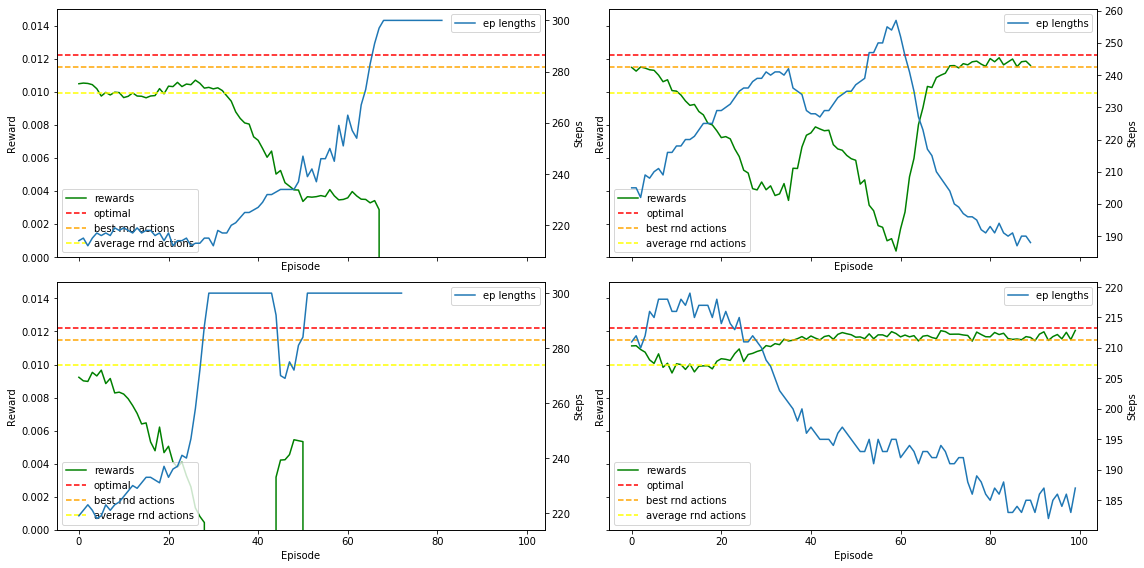

In [6]:
plot_reward_trends(train_logs_ddpg['episode'])

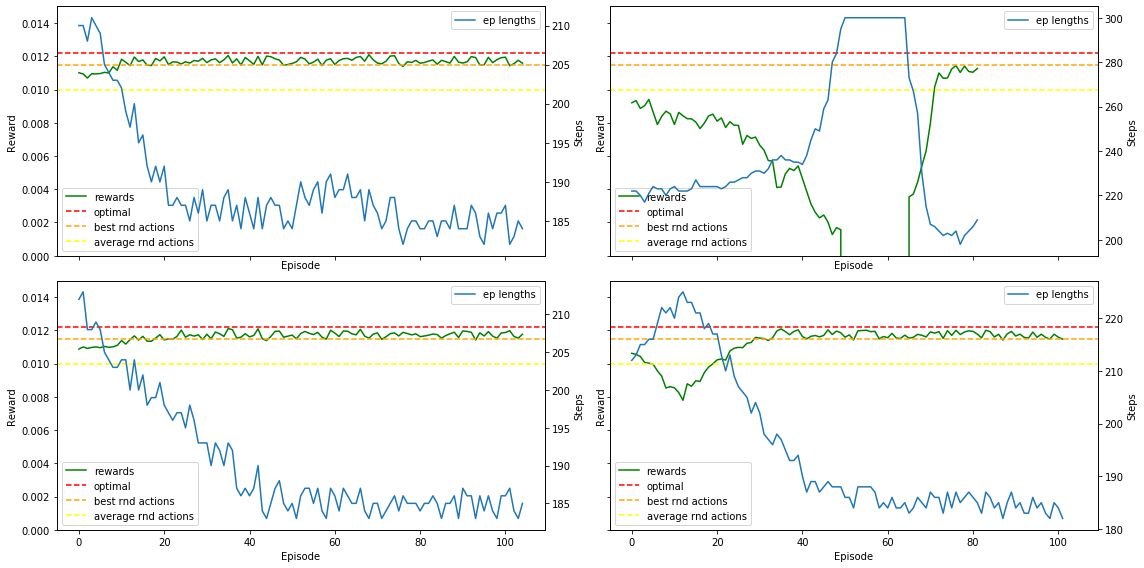

In [7]:
plot_reward_trends(train_logs_ddpg['step_wise'])

Use the following cell to test your agent on the env using deterministic actions

In [8]:
test_agent(train_logs_ddpg['episode'])


Reward during test (0): -1.0



Reward during test (1): 0.011861185768553106



Reward during test (2): -1.0



Reward during test (3): 0.011762651398928847
Optimal control: 0.0122


In [9]:
test_agent(train_logs_ddpg['step_wise'])


Reward during test (0): 0.011846400580121097



Reward during test (1): 0.011035366383060019



Reward during test (2): 0.01187645392090153



Reward during test (3): 0.011849798498402286
Optimal control: 0.0122


### Demo: StableBaselines3 usage

Alternatively, you can use readily available Python packages such as [stable-baselines3](https://github.com/DLR-RM/stable-baselines3) for employment of state-of-the-art algorithms.
In what follows below, the DDPG algorithm as utilized by stable-baselines3 is showcased.

In [10]:
total_timesteps = int(20e3)


class Pbar(BaseCallback):
    def __init__(self):
        super().__init__()
        self.pbar = tqdm(desc='Training', total=total_timesteps)

    def _on_rollout_end(self) -> None:
        """This event is triggered before updating the policy."""
        # self.pbar.update(self.)

    def _on_step(self) -> bool:
        self.pbar.update()
        return True
    
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[8], vf=[8])])

repeats = 4
logs = {'envs': [], 'models': []}
for _ in range(repeats):
    
    env = Monitor(GoddardEnv())
    
    #n_actions = env.action_space.shape[-1]
    #noise_var = 4
    #noise_theta = 25  # stiffness of OU
    #action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), theta=noise_theta * np.ones(n_actions),
    #                                        sigma=noise_var * np.ones(n_actions))
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    
    policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[8] * 1, qf=[8] * 1))
    model = DDPG("MlpPolicy", env, policy_kwargs=policy_kwargs, batch_size=256, device='cpu',
             learning_rate=1e-4, gamma=0.999, learning_starts=500)
    model.learn(total_timesteps=total_timesteps, callback=Pbar())
    logs['envs'] += [env]
    logs['models'] += [model]

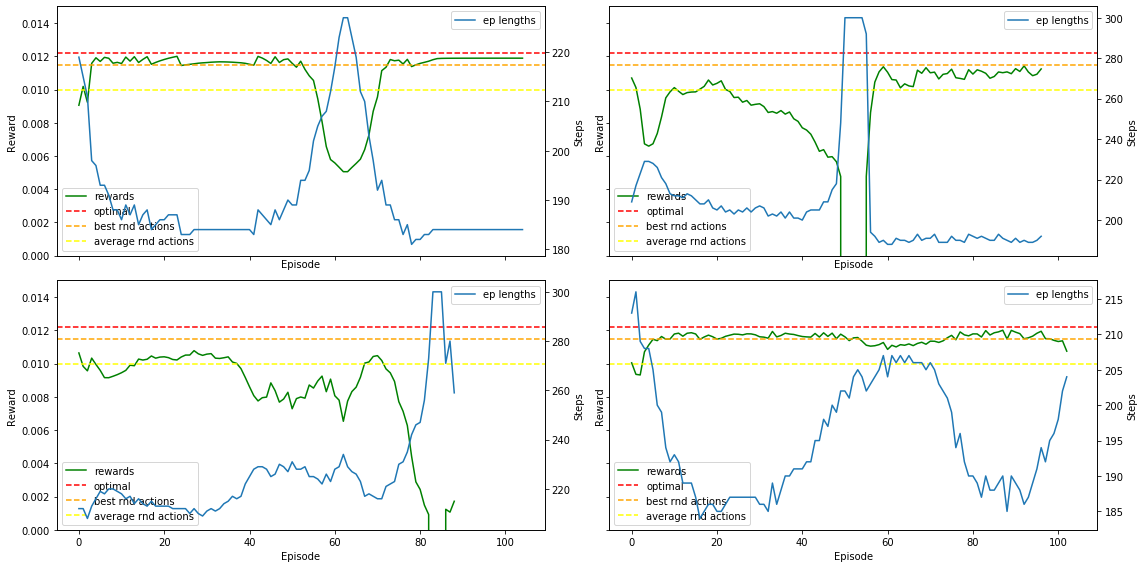

In [11]:
plot_reward_trends(logs)

Use the following cell to execute the last trained agent

In [12]:
n_episodes = 1
max_steps_per_episode = 500
tst_logs = {'rewards': []}
for ep in range(n_episodes):
    state = env.reset()
    done = np.zeros(1, dtype=np.bool)
    cum_rew = 0
    k = 0
    while not np.all(done) and k < max_steps_per_episode:
        action, _ = model.predict(state, deterministic=True) 
        state, reward, done, info = env.step(action)
        env.render()
        cum_rew += reward
        k += 1

    tst_logs['rewards'].append(cum_rew)
rewards = np.array(tst_logs['rewards']).ravel()
env.close()

/home/wilhelmk/tools/anaconda3/envs/tf-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


## 2) PPO

The [original paper from 2017](https://arxiv.org/abs/1707.06347) for the PPO came up with an idea to combine A2C (having multiple workers) and TRPO (using a trust region to improve the actor).
The PPO algorithm achieves this by hard clipping gradients in order to ensure that new policies won't be too far away from old ones.

In contrast to DDPG, PPO is an on-policy algorithm. In order to still apply mini-batch training, there is a so-called roll-out-buffer that is filled up with the current policy, on whose base a gradient ascent update would be done.

There are two variants on the PPO algorithm, from which we will implement the clip variant.

The actor (policy) update is computed according to

\begin{align}
\theta_{k+1} &= \arg \max_{\theta} \underset{\langle x,u \rangle \sim \pi_{\theta_k}}{{\mathbb E}}\left[\mathcal L(X,U,\theta_k, \theta)\right], \\
\mathcal L(x,u,\theta_k,\theta) &= \min\left(
\frac{\pi_{\theta}(u|x)}{\pi_{\theta_k}(u|x)}  A^{\pi_{\theta_k}}(x,u), \;\;
\text{clip}\left(\frac{\pi_{\theta}(u|x)}{\pi_{\theta_k}(u|x)}, 1 - \epsilon, 1+\epsilon \right) A^{\pi_{\theta_k}}(x, u)
\right),
\end{align}
where the expectation operator denotes the empirical average across the roll-out-buffer, $\theta$ the possible next weights of the actor, $\epsilon$ denotes the threshold within the next update is allowed, and $\mathcal L$ the long-term return.

On the opposite side, the critic's weights $\omega_k$ are updated through the plain stochastic mini-batch gradient descent on the mean squared error $\mathcal C$ between immediately seen rewards $r_{k+1}$ and corresponding estimated value $v_{w_k}(x_k)$ across the roll-out-buffer:
\begin{align}
w_{k+1} &\leftarrow \omega_k - \alpha \nabla\mathcal C(X,R_{k+1},\omega_k), \\
\mathcal C(x,r_{k+1}, \omega_k) &= \left(v_{\omega_k} (x_k)- r_{k+1}\right)^2
\end{align}

### Task: Implement the PPO clip variant with PyTorch
Fill in the below code to run the PPO-clip variant on the rocket environment.

For simplicity, do not contemplate a vectorized environment for synchronous training (like in A2C or A3C).
Moreover, calculate the generalized advantage estimate with $\lambda = 1$.

In [13]:
class StochActor(nn.Module):
    """This stochastic actor learns a Gaussian distribution. While the mean value 
    is learnt by a full-fledged MLP, the standard deviation is denoted by a
    single trainable weight. With Pytorch's distribution package, probabilities 
    given a certain distribution and an action can be calculated."""
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # The standard deviation is just one trainable weight
        self.log_std = torch.nn.Parameter(
                        torch.as_tensor(
                            -.5 * np.ones(action_dim, dtype=np.float32)))
        # the mean value is estimated by a full MLP
        self.mu_net = mlp(list(state_dim) + [8] + list(action_dim), nn.Tanh, nn.Sigmoid)
        
    def _distribution(self, state):
        return torch.distributions.normal.Normal(
                self.mu_net(state), torch.exp(self.log_std))
    
    def forward(self, state, action=None):
        pi = self._distribution(state)
        # if action is None, logp_a will be, too
        if action is None:
            logp_a = None
        else:
            logp_a = pi.log_prob(action).sum(axis=-1)
        return pi, logp_a

class PPOAgent:
    """Reference:
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ppo/ppo.py
    """
    
    class RolloutBuffer:
        def __init__(self, size, action_dim, state_dim):
            self.action_buf = np.zeros((size, action_dim[0]), dtype=np.float32)
            self.state_buf = np.zeros((size, state_dim[0]), dtype=np.float32)
            self.rew_buf = np.zeros(size+1, dtype=np.float32)
            self.val_buf = np.zeros(size+1, dtype=np.float32)
            self.logp_buf = np.zeros(size, dtype=np.float32)
            self.i = 0
            self.max_size = size
            
        def push(self, state, action, reward, value, logp):
            """Append a sample to the buffer"""
            ### BEGIN SOLUTION
            self.state_buf[self.i] = state
            self.action_buf[self.i] = action
            self.rew_buf[self.i] = reward
            self.val_buf[self.i] = value
            self.logp_buf[self.i] = logp
            self.i += 1
            ### END SOLUTION
            
        def fetch(self, last_val=None, gamma=0.999):
            """Get all data from the rollout buffer.
            Returns a dictionary for state, action, rewards-to-go, advantages, and logp values.
            Entries might be of different length across multiple calls to this function as episodes
            potentially have different lengths. Rewards-to-go and advantages need to be computed from 
            rewards, values, and gamma, as outlined in https://arxiv.org/abs/1506.02438 (or as done
            in the spinning up implementation). Normalize the advantage batch by standard scaling."""
            ### BEGIN SOLUTION
            if last_val is not None:
                self.rew_buf[self.i] = last_val
                self.val_buf[self.i] = last_val
            rewards = self.rew_buf[:self.i+1]
            values = self.val_buf[:self.i+1]
            
            # Advantage calculaton            
            w = np.arange(rewards.size - 1)
            w = w - w[:, np.newaxis]
            w = np.triu(gamma ** w.clip(min=0)).T
            advantages = rewards[:-1] + gamma * values[1:] - values[:-1]
            advantages = (advantages.reshape(-1, 1) * w).sum(axis=0)
            
            # reward
            rewards_to_go = ((gamma*rewards[:-1]).reshape(-1, 1) * w).sum(axis=0)
            
            # normalize advantages
            advantages = (advantages - advantages.mean()) / np.std(advantages)
            
            data =  {'state': self.state_buf[:self.i],
                     'action': self.action_buf[:self.i],
                     'rewards_to_go': rewards_to_go.copy(),  # make stride positive
                     'advantages': advantages, 
                     'logp': self.logp_buf[:self.i]}
            self.i = 0
            
            return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in data.items()}
            ### END SOLUTION
    
    def __init__(self, buffer_size, env):
        self.buf = self.RolloutBuffer(buffer_size, action_dim=env.action_space.shape,
                                 state_dim=env.observation_space.shape)
        # use the below attributes for the actor-critic agent
        self.actor = None
        self.critic = None
        self.n_epochs = 8
        self.clip_ratio = 0.1
        ### BEGIN SOLUTION
        
        self.actor = StochActor(action_dim=env.action_space.shape, state_dim=env.observation_space.shape)
        self.critic = mlp(list(env.observation_space.shape) + [8, 1], nn.Tanh, nn.Tanh)
        self.pi_opt = Adam(self.actor.parameters(), lr=1e-3)
        self.v_opt = Adam(self.critic.parameters(), lr=1e-3)
        
        ### END SOLUTION

    
    def v_loss(self, data):
        ### BEGIN SOLUTION
        state, rewards_to_go = data['state'], data['rewards_to_go']
        return ((self.critic(state).squeeze(-1) - rewards_to_go)**2).mean()
        ### END SOLUTION
    
    def pi_loss(self, data):
        ### BEGIN SOLUTION
        state, action, advantage, logp_old = [data[k] for k 
                                              in ('state', 'action', 'advantages', 'logp')]
        
        pi, logp = self.actor(state, action)
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1-self.clip_ratio, 1+self.clip_ratio) * advantage
        loss_pi = -(torch.min(ratio * advantage, clip_adv)).mean()
        
        return loss_pi
        ### END SOLUTION
    
    def deliberate(self, last_value=None):
        """Fetch the rollout buffer for all samples.
        Train the actor and critic for n_epochs by computing the pi and v
        loss iteratively.
        The rewards and values buffer needs a zero appended for terminal states,
        or the critic's estimate appended in case of intermediate states 
        that result from timeout. This is denoted by last_value."""
        ### BEGIN SOLUTION
        batch = self.buf.fetch(last_value)
        loss_pi_old = self.pi_loss(batch).item()
        loss_v_old = self.v_loss(batch).item()
        
        # update policy n_epoch times
        for _ in range(self.n_epochs):
            self.pi_opt.zero_grad()
            loss_pi = self.pi_loss(batch)
            loss_pi.backward()
            self.pi_opt.step()
        
            self.v_opt.zero_grad()
            loss_v = self.v_loss(batch)
            loss_v.backward()
            self.v_opt.step()
        
        ### END SOLUTION
    
    def decide(self, state, deterministic=False):
        """Receive a state as torch tensor and return a tuple of numpy ndarrays
        in the form (action, value, log-probability-of-action-under-pi)"""
        ### BEGIN SOLUTION
        state = torch.as_tensor(state, dtype=torch.float32)
        with torch.no_grad():
            pi = self.actor._distribution(state)
            if deterministic:
                return pi.mean.numpy()
            else:
                a = pi.sample()
            logp_a = pi.log_prob(a).sum(axis=-1)
            v = self.critic(state)
        return a.numpy(), v.numpy(), logp_a.numpy()
        ### END SOLUTION
        
    

In [14]:
# main training loop

n_episodes = 250
max_steps_per_episode = 500
train_logs_ppo_custom = {'envs': [], 'models': []}

def train_ppo(repeats):
    for rep in range(repeats):
        env = Monitor(GoddardEnv())
        agent = PPOAgent(max_steps_per_episode, env)

        for ep in tqdm(range(n_episodes), desc='Training'):
            state = env.reset()
            done = False
            k = 0
            while not done and k < max_steps_per_episode:
                action, value, logp_a = agent.decide(state) 
                next_state, reward, done, info = env.step(action)

                # track experience
                agent.buf.push(state, action, reward, value, logp_a)

                state = next_state
                k += 1

            # if episode finished with done signal, the long term value should be 0
            #  for this terminal state
            if done:
                last_value = None
            else:
                _, last_value, _ = self.decide(state)
            agent.deliberate(last_value)

        train_logs_ppo_custom['envs'] += [env]
        train_logs_ppo_custom['models'] += [agent]
        env.close()
train_ppo(4)

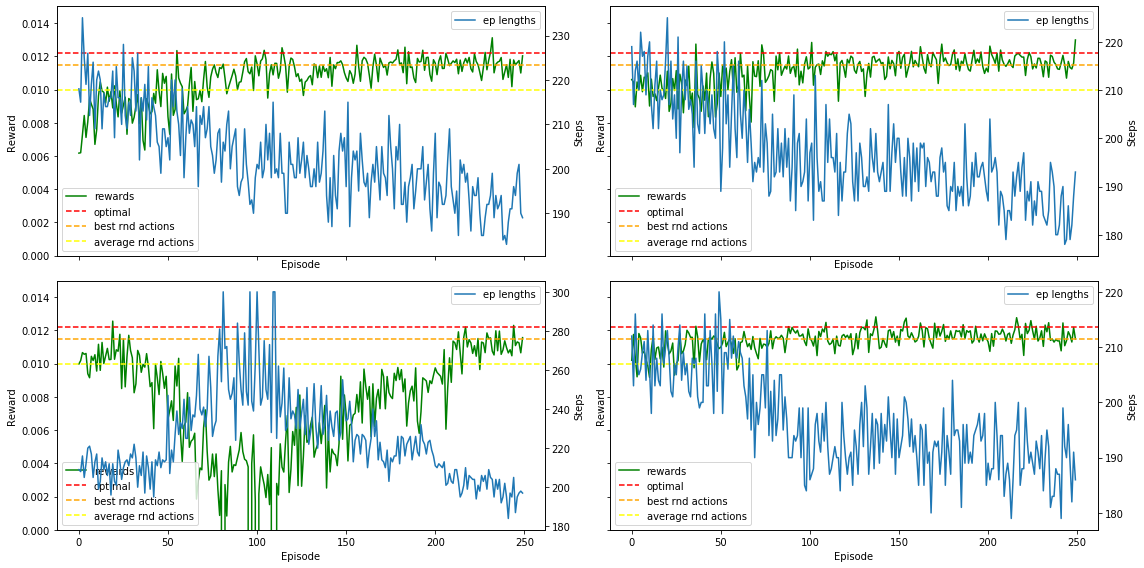

In [15]:
plot_reward_trends(train_logs_ppo_custom)

In [16]:
test_agent(train_logs_ppo_custom)


Reward during test (0): 0.01202398780966707



Reward during test (1): 0.011901507527816824



Reward during test (2): 0.01186353153602493



Reward during test (3): 0.011754158952783422
Optimal control: 0.0122


In [17]:
# more samples
train_ppo(46)

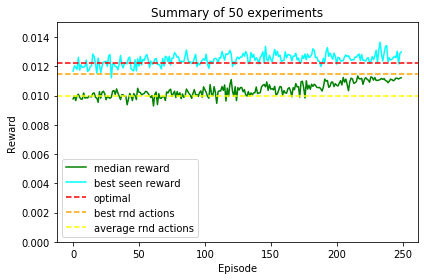

In [27]:
# plot average and standard deviation of 50 runs
repeats = len(train_logs_ppo_custom['envs'])
rewards_mat = np.asarray([_env.get_episode_rewards()[:250] for _env in train_logs_ppo_custom['envs']])
rewards_average = np.median(rewards_mat, axis=0)
rewards_std = rewards_mat.std(axis=0)

plt.figure()
ax = plt.gca()
ax.plot(rewards_average, color='green', label='median reward')
ax.plot(rewards_mat.max(axis=0), color='cyan', label='best seen reward')
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')
ax.set_ylim(0, 0.015)
ax.axhline(OPTIMAL_CONTROL, ls='--', color='red', label='optimal')
ax.axhline(RANDOM_BEST, ls='--', color='orange', label='best rnd actions')
ax.axhline(RANDOM_AVG, ls='--', color='yellow', label='average rnd actions')
ax.legend(loc='lower left')
ax.set_title('Summary of 50 experiments')
plt.tight_layout()

Very strong performance is sometimes achieved even within 10 training episodes. Here, the 'optimal' performance is based on an analytical solution using a continuous-time model (planning) which is applied to an approximate discrete-time rocket simulation. Hence, there is a systematic deviation between the model of the analytical solution and the actual simulation behavior (i.e., it is actual non-optimal w.r.t. the simplified simulation).

The low median reward curve shows that several repetitions of an algorithm are inevitable for a robust assessment.

### Demo: StableBaselines3 usage

Alternatively you can use readily available Python packages such as [stable-baselines3](https://github.com/DLR-RM/stable-baselines3) for employment of state-of-the-art algorithms.
In what follows below, the PPO algorithm as utilized by stable-baselines3 is showcased.

In [ ]:
class Pbar(BaseCallback):
    """This is a callback that helps monitoring the training progress"""
    def __init__(self, total, n_rollout_steps):
        super().__init__()
        self.n_steps = n_rollout_steps
        self.pbar = tqdm(desc='Training', total=total)
        
    def _on_rollout_end(self) -> None:
        """This event is triggered before updating the policy."""
        self.pbar.update(self.n_steps)
    
    def _on_step(self) -> bool:
        return True

    
policy_kwargs = dict(activation_fn=torch.nn.Sigmoid, net_arch=[dict(pi=[8], vf=[8])])

n_steps = 256  # an episode takes around ~250 steps
total_timesteps = n_steps*250  # steps_per_episode * episodes

repeats = 4  # repeat experiment x times to assess scatter through random init
train_logs_ppo_sb3 = {'envs': [], 'models': []}
for _ in range(repeats):
    
    env = Monitor(GoddardEnv())
    model = PPO('MlpPolicy', env, n_steps=n_steps, n_epochs=8,  verbose=0, device='cpu', learning_rate=1e-3, batch_size=n_steps, policy_kwargs=policy_kwargs,
               clip_range=0.1, clip_range_vf=0.1, gamma=0.999)
    model = model.learn(total_timesteps=total_timesteps, callback=Pbar(total_timesteps, n_steps))
    train_logs_ppo_sb3['envs'] += [env]
    train_logs_ppo_sb3['models'] += [model]

In [ ]:
plot_reward_trends(train_logs_ppo_sb3)

Obviously, the chosen architecture and hyper parameters do well often, but can also fail abruptly. 
What might be the reason for these failures?